In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

In [4]:
# TRACTOR = 'Huerlimann_D115'
# TRACTOR = 'Huerlimann_D210'
# TRACTOR = 'Fiat_1300_DT'
TRACTOR = 'Fiat_56'# kalt

In [5]:
files = {
    'Fiat_56': 'fixed/Fiat_56_kalt.csv',
    'Huerlimann_D115': 'fixed/Hürlimann_D115_schlepp.csv',
    'Huerlimann_D210': 'fixed/Hürlimann_D210_schlepp.csv',
    'Fiat_1300_DT': 'fixed/Fiat_1300DT_schlepp.csv'
}

files2 = {
    'Fiat_56': 'volllast/Volllastkennlinie_Fiat_56-66.csv',
    'Huerlimann_D115': 'volllast/Volllastkennlinie_Hürlimann_D_115.csv',
    'Huerlimann_D210': 'volllast/Volllastkennlinie_Hürliman_D_210.csv',
    'Fiat_1300_DT': 'volllast/Volllastkennlinie_Fiat_1300DT.csv'
}

names = {
    'Fiat_56': 'Fiat 56-66',
    'Fiat_1300_DT': 'Fiat 1300 Super',
    'NewhollandT6.180': 'NewhollandT6.180',
    'NewhollandT6.175': 'NewhollandT6.175',
    'NewhollandT5.140': 'NewholladnT5.140',
    'Huerlimann_D115': 'Hürlimann D115 TA',
    'Huerlimann_D210': 'Hürlimann D210 Synchromat'
}

df = pd.read_csv(files[TRACTOR])
volllast = pd.read_csv(files2[TRACTOR])

In [7]:
# remove unused excel header rows
# df = df.iloc[2:]

# sensor deviation factor, as sensor did not measure very correctly.
# using the first 20 values and match them to zero, as first readings should
# have been zero if sensor measured correctly. for some tractors this does not work
# as the measurement did not start at 0. hardcode some manually calculated values
# Setoffs
# Fiat Kalt: -0.3438337
# Fiat 1300 DT: -0.3238276
# Hürlimann D115: -0.2414296
# Hürlimann D210: -0.3087383
SENSOR_DEVIATION_FACTOR = df['Ch1'].iloc[:20].mean()
if TRACTOR == 'Fiat_56':
    SENSOR_DEVIATION_FACTOR = -0.3438337
df['Ch1'] = df['Ch1'] - SENSOR_DEVIATION_FACTOR

# convert Ch1 [Volt] to Newtonmeter
VOLT_TO_NEWTON_FACTOR = 299.2606857
df['Ch1'] = df['Ch1'] * VOLT_TO_NEWTON_FACTOR

# Convert Newtonmeter to negative, as its breaking force
df['Ch1'] = df['Ch1'] * (-1)

# RPM Conversion measured at measuring device converted to Motor mit Schlepp
# Schlepp: Zapfenwelle Grösse 1000er
RPM_RATIOS_SCHLEPP = {
    'Fiat_56': 3.066, # Zapfenwelle 750er
    'NewhollandT5.140': 2.0023,
    'NewhollandT6.175': 1.91,
    'NewhollandT6.180': 1.89,
    'Fiat_1300_DT': 2.1,
    'Huerlimann_D115': 2.0,
    'Huerlimann_D210': 2.0
}
df['RPM-Value-Motor'] = df['RPM-Value'] # * RPM_RATIOS_SCHLEPP[TRACTOR]

# Convert Nm from Zapfwelle (PTO) to Nm Motor
df['Ch1'] = df['Ch1'] / RPM_RATIOS_SCHLEPP[TRACTOR]

# fix object to float types
df['Zeit'] = df['Zeit'].astype(float)
df['Ch1'] = df['Ch1'].astype(float)
df['RPM-Value'] = df['RPM-Value'].astype(int)
df['RPM-Value-Motor'] = df['RPM-Value-Motor'].astype(float)

df

yes


,Unnamed: 0,Zeit,Ch1,RPM-Value,RPM-Value-Motor
0,0,99.993436,-45.872376,1400,1400.000000
1,1,100.144483,-48.520132,1400,1400.228728
2,2,100.295531,-68.279014,1400,1400.457457
3,3,100.446578,-82.907867,1400,1400.686185
4,4,100.597626,-48.487035,1400,1400.914913
...,...,...,...,...,...
4368,4368,759.768855,-112.066283,2399,2399.085087
4369,4369,759.919903,-102.401972,2399,2399.313815
4370,4370,760.070950,-85.092266,2399,2399.542543
4371,4371,760.221997,-85.919690,2399,2399.771272


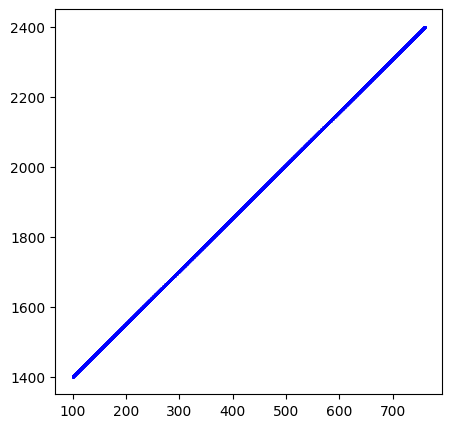

In [9]:
plt.figure(figsize=(5, 5))

# show all points
plt.scatter(data=df, x='Zeit', y='RPM-Value-Motor', color='blue', alpha=1, s=1, label='')

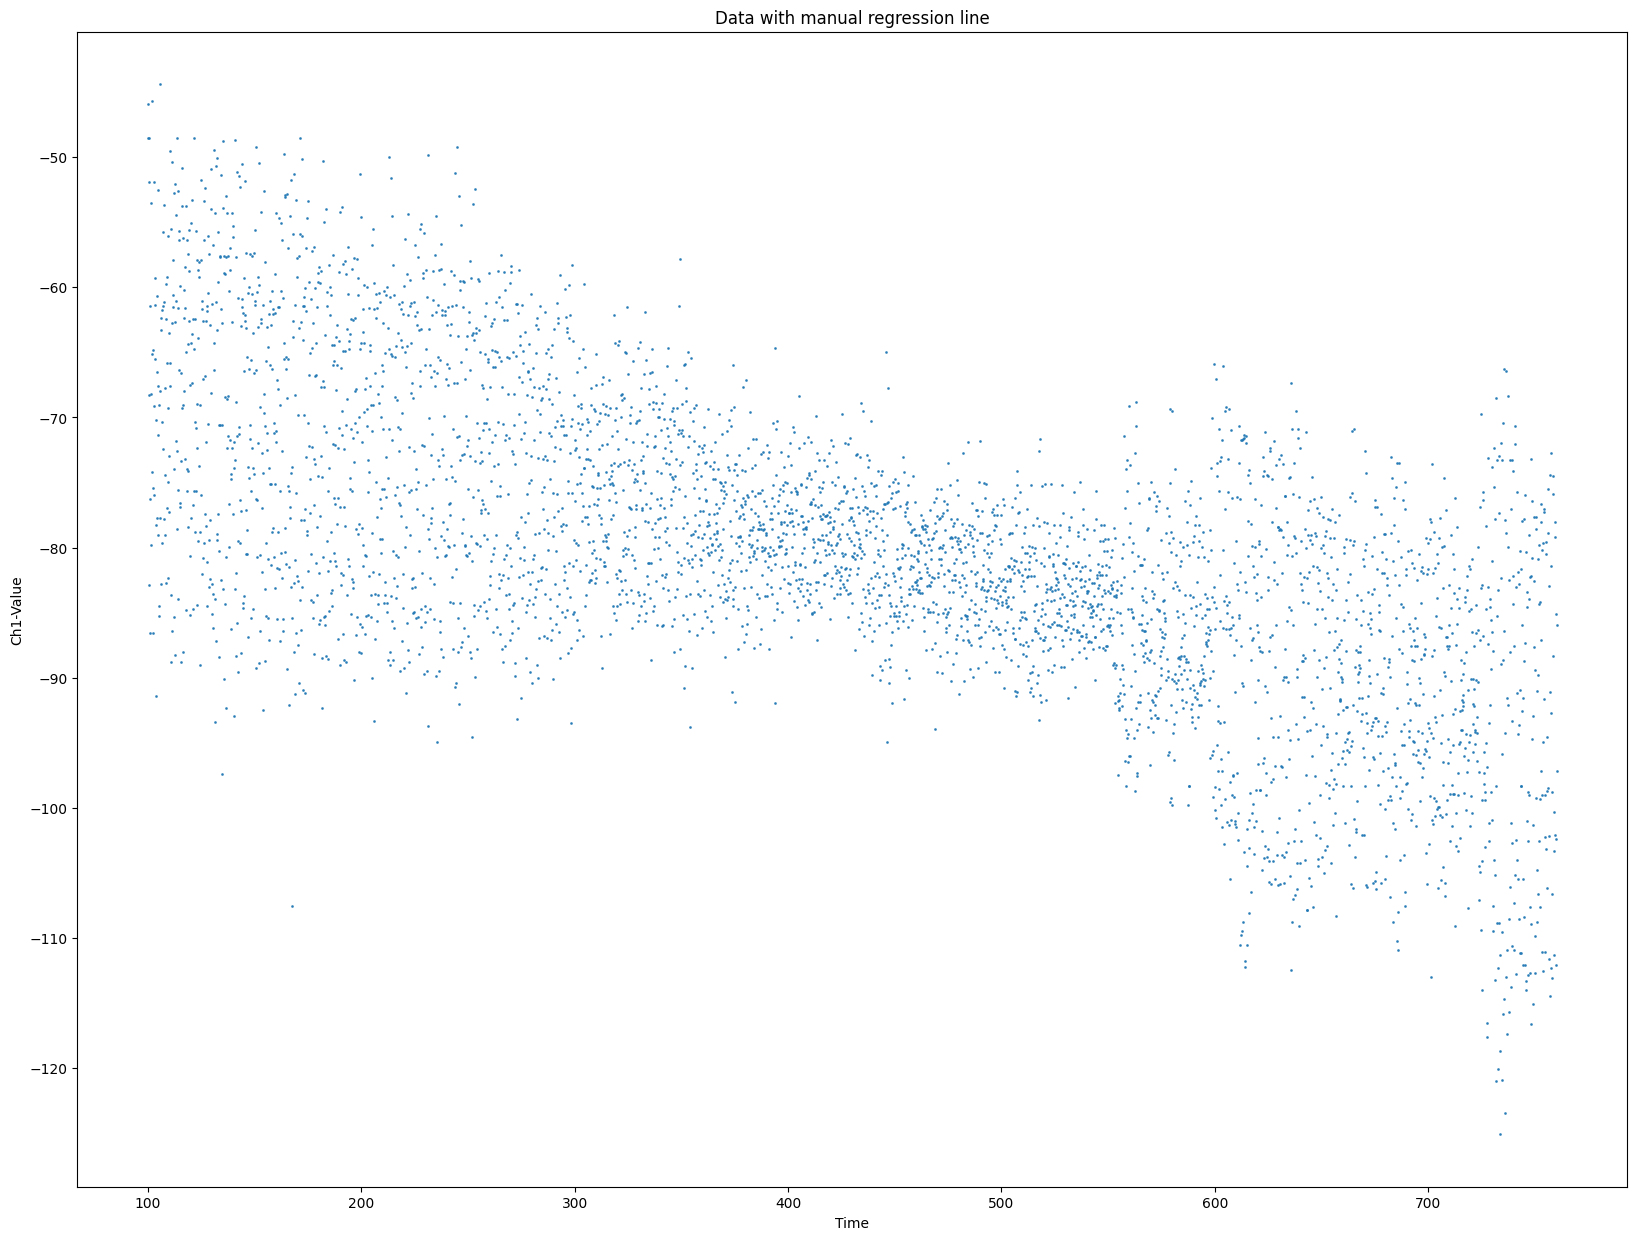

In [10]:
# save start and end for good plots, to remove long pre-/postfix data
ranges = {
    'Fiat_56': (0, 10000),
    'Huerlimann_D115': (30, 560),
    'Huerlimann_D210': (0, 6000),
    'Fiat_1300_DT': (0, 10000)
}
# define two points for each tractor to find a fitting separation line for the data
points = {
    'Fiat_56': ((0,0), (500,500)),
    'Fiat_1300_DT': ((0,0), (500,500)),
    'Huerlimann_D115': ((100, 100), (500, 200)),
    'Huerlimann_D210': ((100, 100), (500, 200))
}
start, end = ranges[TRACTOR]
df = df[(df['Zeit'] > start) & (df['Zeit'] < end)]

plt.figure(figsize=(20, 15))

#visualize data and regression line
plt.scatter(df['Zeit'], df['Ch1'], alpha=0.8, s=1) # scatter plot of datapoints
plt.title("Data with manual regression line")
plt.xlabel("Time")
plt.ylabel("Ch1-Value")
plt.show()

In [11]:
imprecise = ['Fiat_56', 'Fiat_1300_DT']


if TRACTOR in imprecise:
    print("Removed Outliers")
    ### Above Line Filtering with Rolling Window

    # Set the window size and threshold for filtering
    window_size = 80
    threshold = 40

    # Sort the DataFrame by the x-axis values (assuming it's called 'x_column')
    df_sorted = df.sort_values(by='RPM-Value-Motor')

    # Calculate the rolling median for the 'RPM-Value-Motor' column
    df_sorted['rolling_median'] = df_sorted['Ch1'].rolling(window=window_size, center=True).median()

    # Filter out points more than the threshold away from the rolling median
    df_filtered = df_sorted[abs(df_sorted['Ch1'] - df_sorted['rolling_median']) <= threshold]

    # Remove the 'rolling_median' column
    df = df_filtered.drop(columns=['rolling_median'])

Removed Outliers


In [12]:
# computes confidence interval for 95%
def regression_ci(x, y, degree, ci=95):
    """
    Compute the confidence interval for a polynomial regression
    of degree `degree` fit to the data `x` and `y` at the given
    `ci` level of confidence.
    
    Returns a tuple (coeffs, lower, upper) where coeffs are the
    polynomial coefficients, lower and upper are vectors giving
    the lower and upper bounds of the confidence interval at
    each `x` value.
    """
    coeffs = np.polyfit(x, y, degree)
    line_function = np.poly1d(coeffs)
    
    # compute predicted values and standard error
    y_hat = line_function(x)
    resid = y - y_hat
    df = x.size - (degree + 1)
    mse = np.sum(resid ** 2) / df
    se = np.sqrt(mse * (1 + 1/x.size + (x - np.mean(x)) ** 2 / np.sum((x - np.mean(x)) ** 2)))
    
    # compute confidence bounds
    alpha = 1 - ci / 100
    tval = np.abs(stats.t.ppf(alpha/2, df))
    lower = line_function(x) - tval * se
    upper = line_function(x) + tval * se
    
    return coeffs, lower, upper

In [13]:
TRACTOR

'Fiat_56'

/home/nya/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3378: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_96901/2038172079.py:15: RankWarning: Polyfit may be poorly conditioned
  coeffs, lower, upper = regression_ci(sorted_data['RPM-Value-Motor'], sorted_data['Ch1'], 10, ci=95)


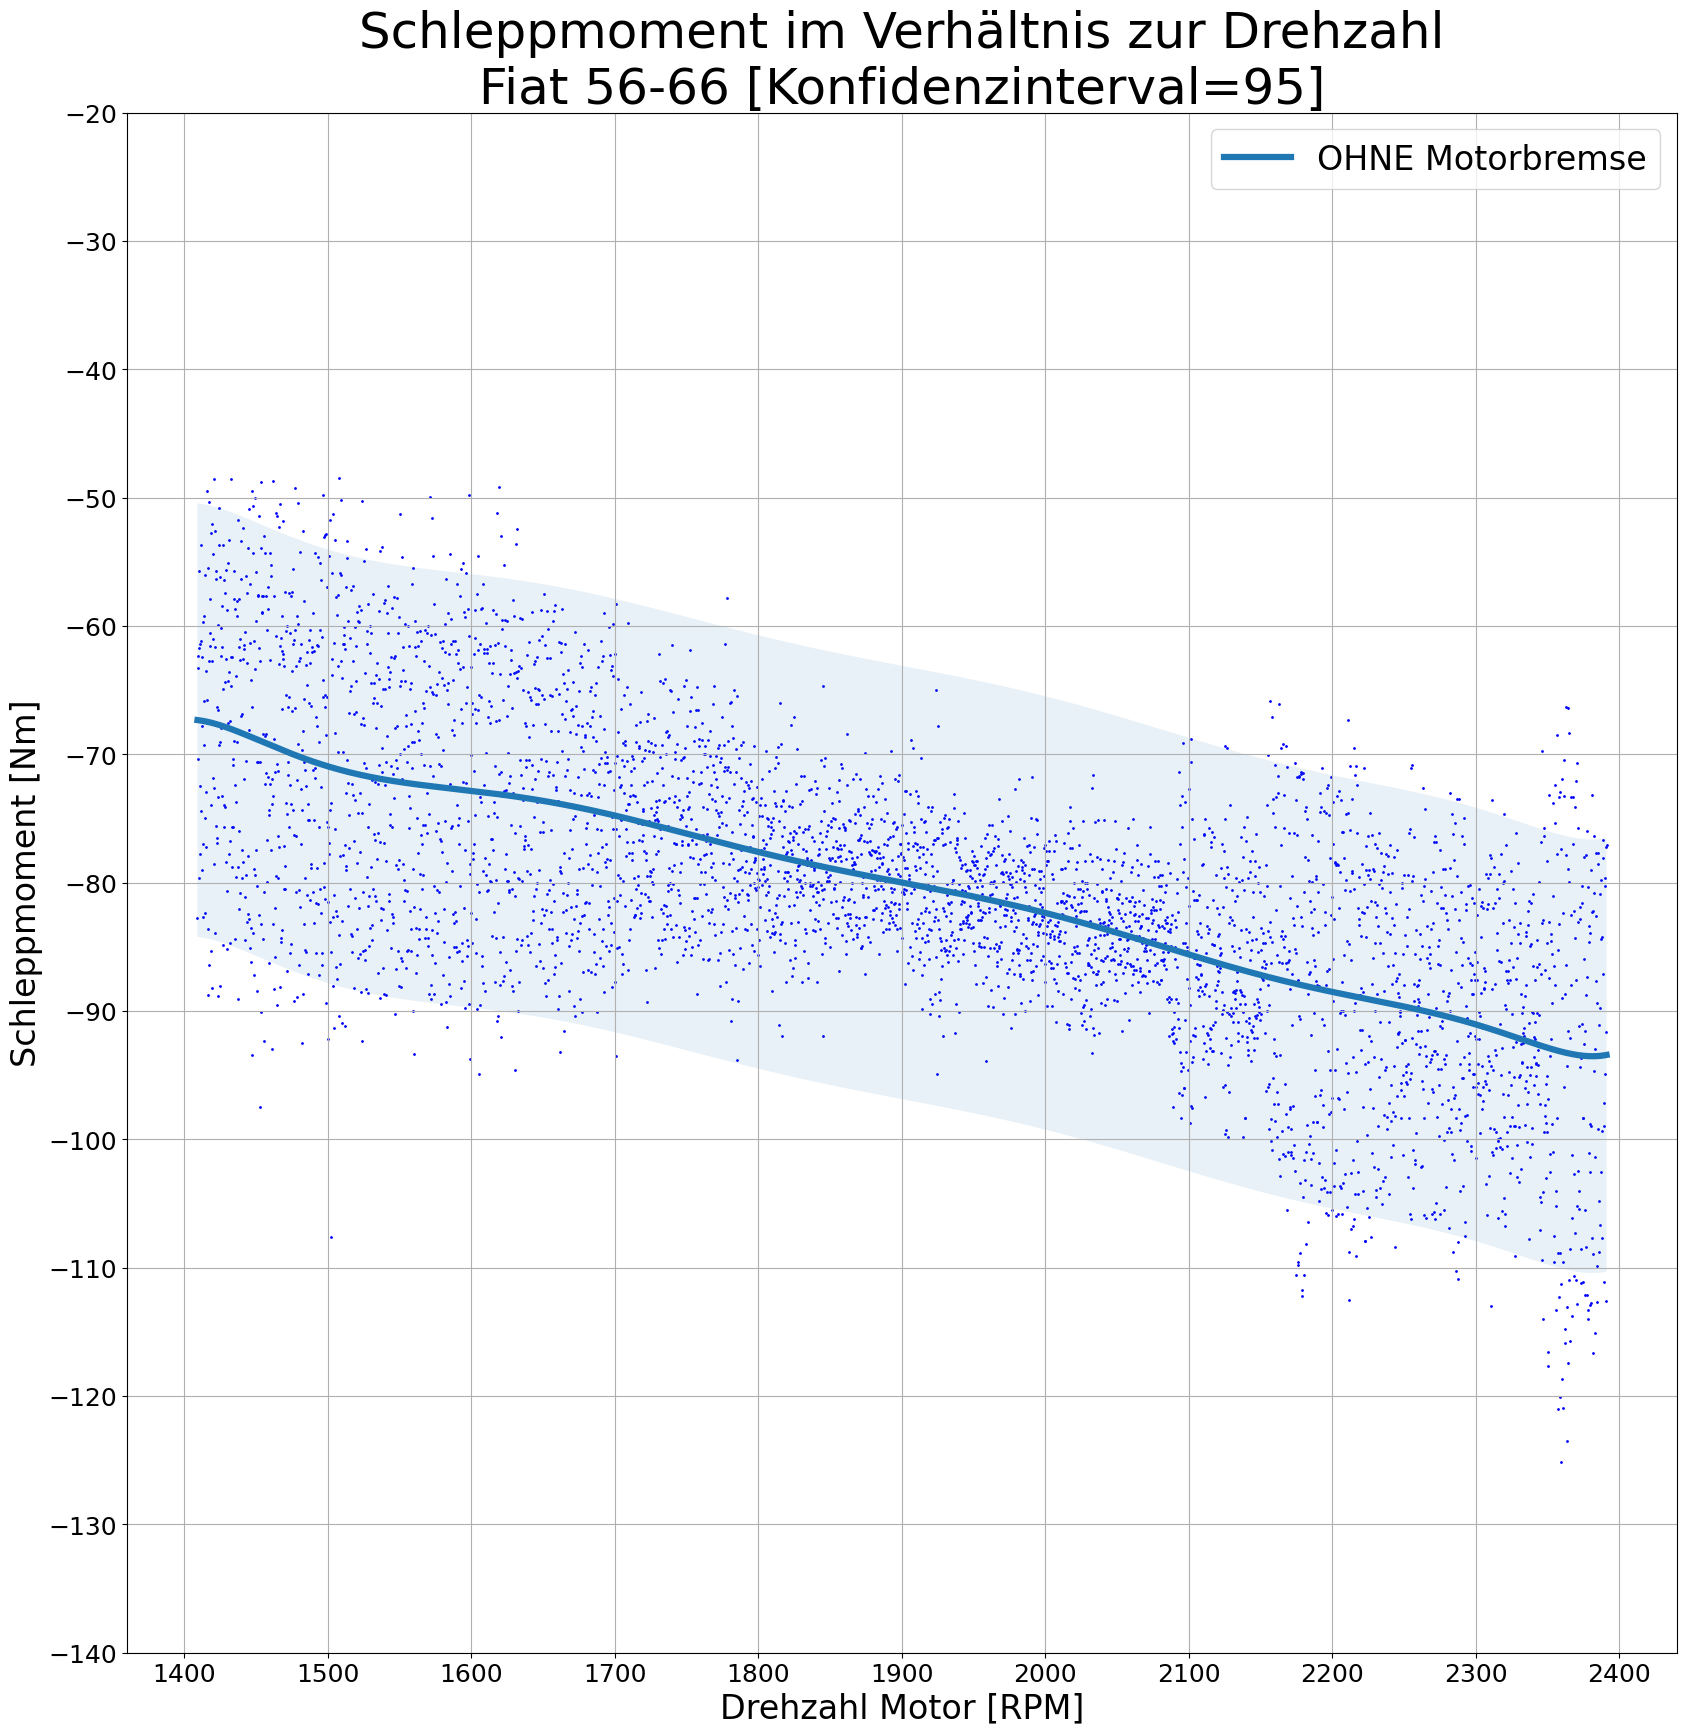

In [14]:
plt.figure(figsize=(20, 20))

# show all points
plt.scatter(data=df, x='RPM-Value-Motor', y='Ch1', color='blue', alpha=1, s=1, label='')


# # # fit and plot regression lines above_line and below_line
# fit linear regression
sorted_data = df.sort_values(by='RPM-Value-Motor')
coefficients = np.polyfit(sorted_data['RPM-Value-Motor'], sorted_data['Ch1'], 10)
line_function = np.poly1d(coefficients)
# plot line with label
plt.plot(sorted_data['RPM-Value-Motor'], line_function(sorted_data['RPM-Value-Motor']), label='OHNE Motorbremse', linewidth=4.5)

coeffs, lower, upper = regression_ci(sorted_data['RPM-Value-Motor'], sorted_data['Ch1'], 10, ci=95)
# plot confidence interval
plt.fill_between(sorted_data['RPM-Value-Motor'], lower, upper, alpha=0.1)

# # set labels and title
plt.xlabel('Drehzahl Motor [RPM]', fontsize=24)
plt.ylabel('Schleppmoment [Nm]', fontsize=24)
plt.title(f"Schleppmoment im Verhältnis zur Drehzahl\n{names[TRACTOR]} [Konfidenzinterval=95]", fontsize=36)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
# Set tick positions on the y-axis on divisible by 10
ystart = np.ceil(df['Ch1'].min()/10) * 10 - 30 # - 50
yend = np.ceil(df['Ch1'].max()/10) * 10 + 50
plt.yticks(np.arange(ystart + 10, yend - 20, 10))
# # Set tick positions on the x-axis
xstart = np.ceil(df['RPM-Value-Motor'].min()/100) * 100
xend = np.ceil(df['RPM-Value-Motor'].max()/100) * 100
plt.xticks(np.arange(xstart - 100, xend + 100, 100))
plt.grid(which='both')
plt.legend(loc=1, fontsize=24)

plt.ion()
plt.savefig(f"graphs/{TRACTOR}_schlepp.png")

In [15]:
df.to_csv("fiat_kalt_cleaned.csv")

In [16]:
volllast = pd.read_csv(files2[TRACTOR], sep="\t")
volllast.rename(columns={'RPM': 'RPM-Value-Motor', 'Drehmoment[Nm]': 'Ch1'}, inplace=True)
sorted_volllast = volllast.sort_values(by='RPM-Value-Motor')

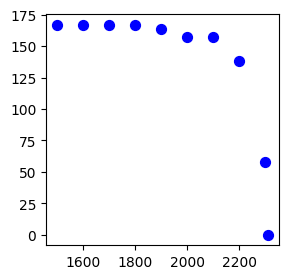

In [17]:
plt.figure(figsize=(3, 3))
plt.scatter(data=sorted_volllast, x='RPM-Value-Motor', y='Ch1', color='blue', alpha=1, s=50, label='')
plt.show()

/home/nya/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3378: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/tmp/ipykernel_96901/367188857.py:17: RankWarning: Polyfit may be poorly conditioned
  coeffs, lower, upper = regression_ci(sorted_data['RPM-Value-Motor'], sorted_data['Ch1'], 10, ci=95)


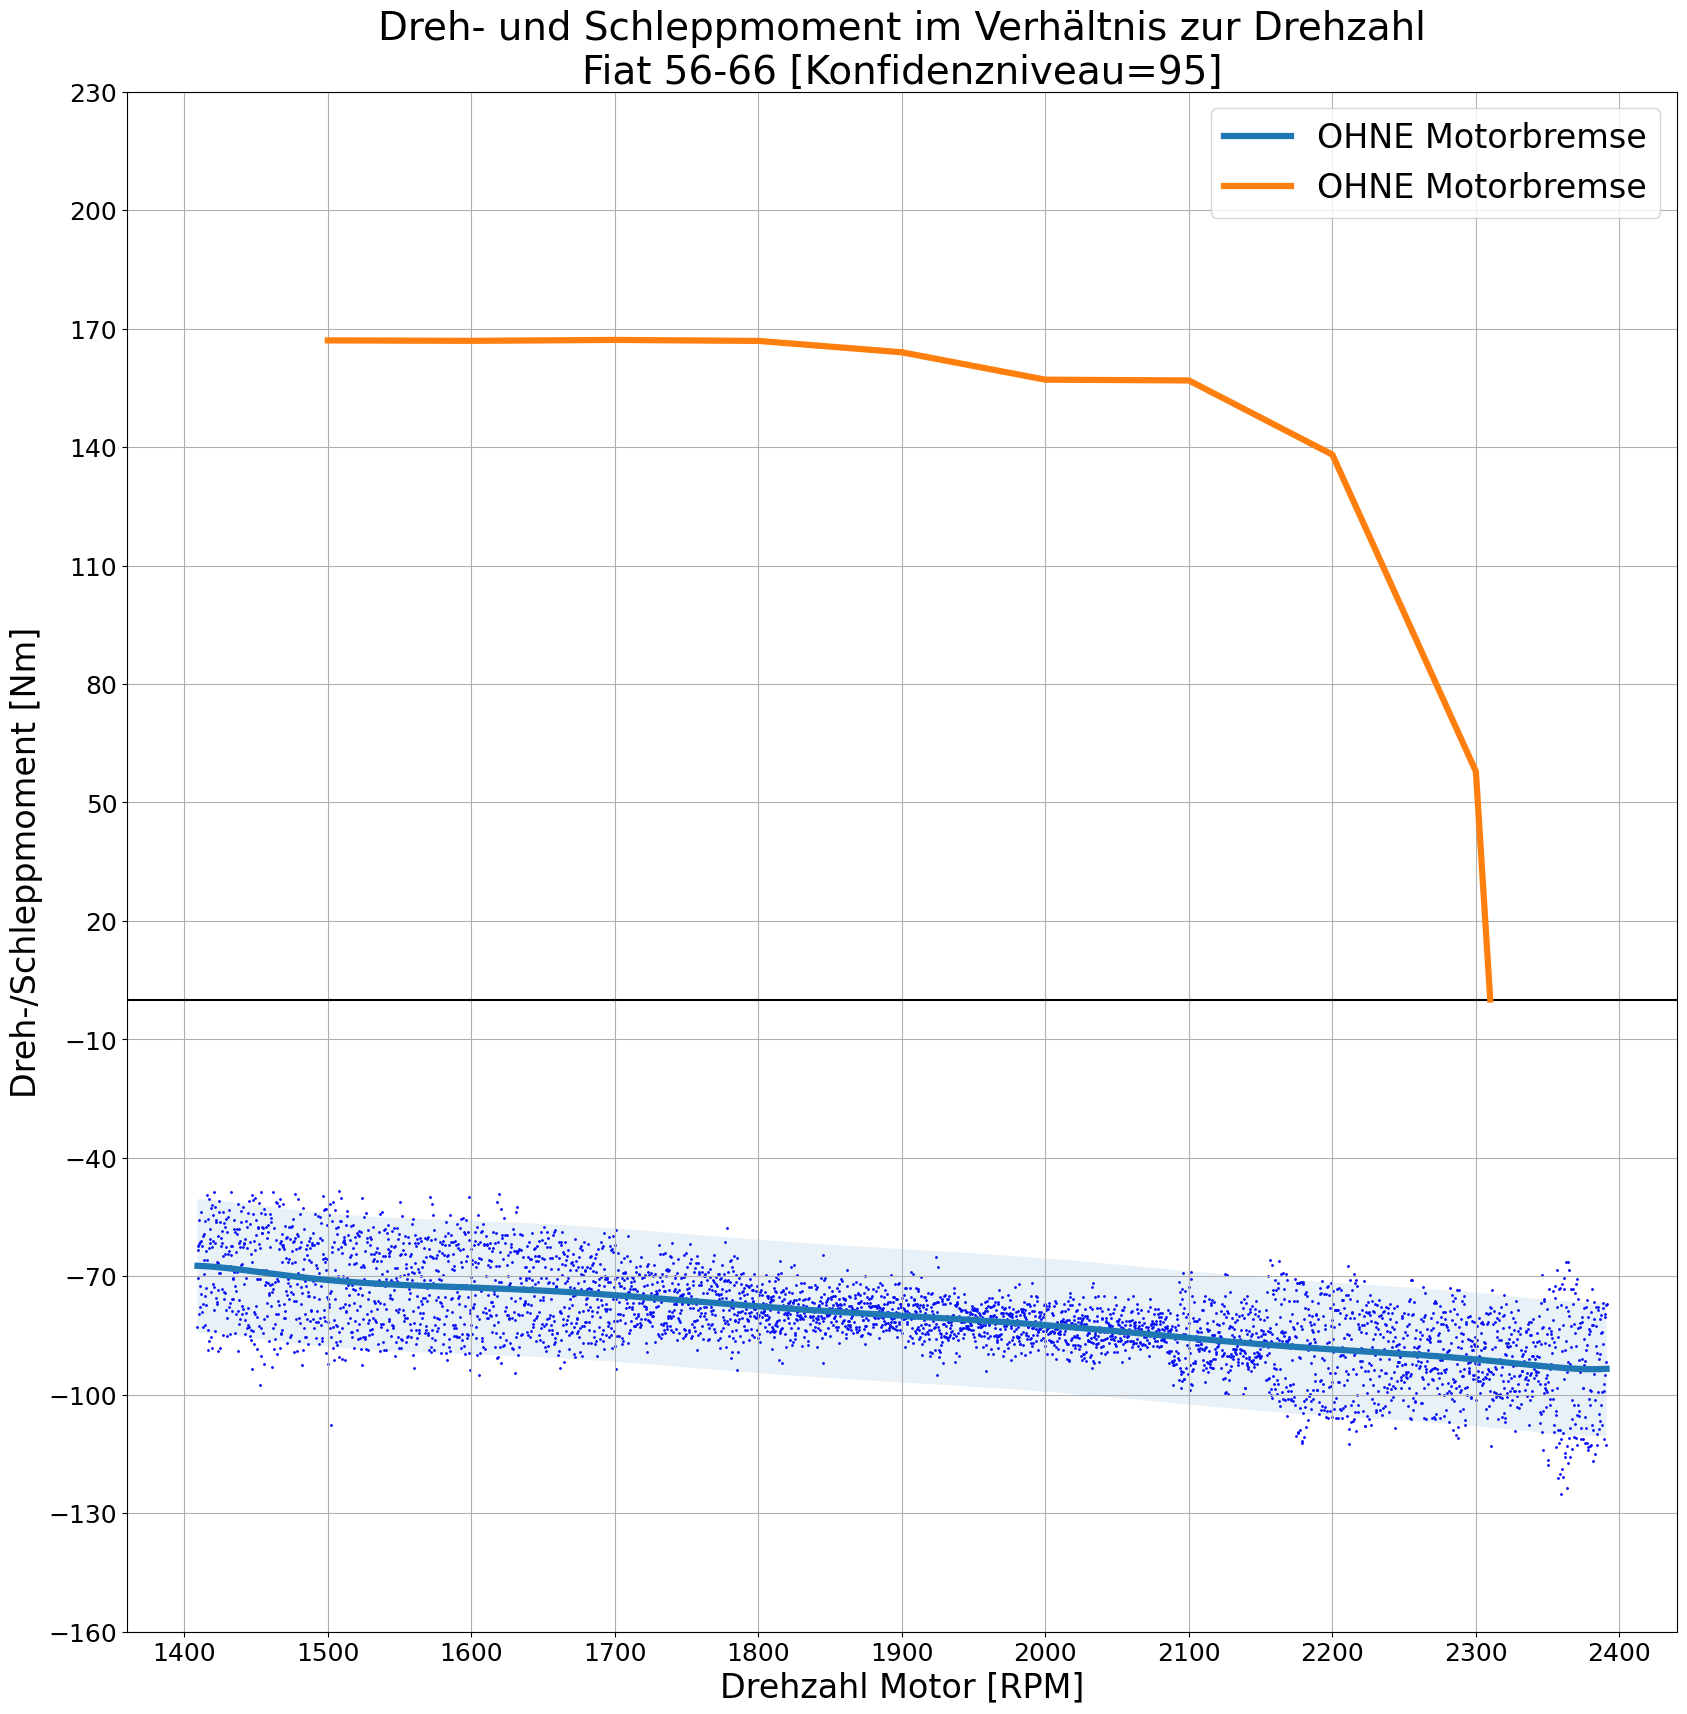

In [18]:
from scipy.interpolate import UnivariateSpline

plt.figure(figsize=(20, 20))

# show all points
plt.scatter(data=df, x='RPM-Value-Motor', y='Ch1', color='blue', alpha=1, s=1, label='')
plt.scatter(data=sorted_volllast, x='RPM-Value-Motor', y='Ch1', color='orange', alpha=1, s=1, label='')

# # fit and plot regression lines above_line and below_line
for name, data in [('OHNE Motorbremse', df)]:
    # fit linear regression
    sorted_data = data.sort_values(by='RPM-Value-Motor')
    coefficients = np.polyfit(sorted_data['RPM-Value-Motor'], sorted_data['Ch1'], 10)
    line_function = np.poly1d(coefficients)
    plt.plot(sorted_data['RPM-Value-Motor'], line_function(sorted_data['RPM-Value-Motor']), label=f'{name}', linewidth=4.5)

    coeffs, lower, upper = regression_ci(sorted_data['RPM-Value-Motor'], sorted_data['Ch1'], 10, ci=95)
    # plot confidence interval
    plt.fill_between(sorted_data['RPM-Value-Motor'], lower, upper, alpha=0.1)

plt.axhline(y=0, color='black', linewidth=1.5)


# Create and fit UnivariateSpline
X = np.array(sorted_volllast['RPM-Value-Motor'])
y = np.array(sorted_volllast['Ch1'])
spline = UnivariateSpline(X, y, s=0.1)  # Adjust 's' parameter to control the smoothness

# Predict and plot the fitted curve
y_pred = spline(X)
plt.plot(sorted_volllast['RPM-Value-Motor'], y_pred, label=f'{name}', linewidth=4.5)

# # set labels and title
plt.xlabel('Drehzahl Motor [RPM]', fontsize=24)
plt.ylabel('Dreh-/Schleppmoment [Nm]', fontsize=24)
plt.title(f"Dreh- und Schleppmoment im Verhältnis zur Drehzahl\n{names[TRACTOR]} [Konfidenzniveau=95]", fontsize=28)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
# Set tick positions on the y-axis on divisible by 10
ystart = np.ceil(df['Ch1'].min()/10) * 10 - 50
yend = np.ceil(volllast['Ch1'].max()/10) * 10 + 100
plt.yticks(np.arange(ystart + 10, yend - 20, 30))
# # Set tick positions on the x-axis
xstart = np.ceil(df['RPM-Value-Motor'].min()/100) * 100
xend = np.ceil(max(df['RPM-Value-Motor'].max(), volllast['RPM-Value-Motor'].max())/100) * 100
plt.xticks(np.arange(xstart - 100, xend + 100, 100))
plt.grid(which='both')
plt.legend(loc=1, fontsize=24)

plt.ion()
plt.savefig(f"graphs/{TRACTOR}_volllast.png")